In [3]:
# to make this notebook's output stable across runs
import numpy as np
import os
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

IMAGES_PATH = "/home/tuandinh/Desktop/ML and AI/Master Machine Learning/images"
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

> + kể từ Scikit-Learn 0.24, `fetch_openml ()` trả về một Pandas `DataFrame` theo mặc định. Để tránh điều này và giữ nguyên mã như trong sách, chúng tôi sử dụng `as_frame = False`.

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

> + There are 70,000 images, and each image has 784 features

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

Saving figure some_digit_plot


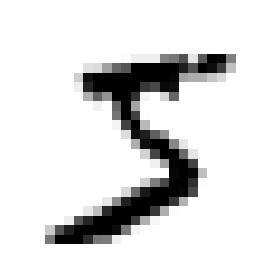

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [8]:
y[0]

'5'

In [9]:
y = y.astype(np.uint8)

In [10]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.binary,
            interpolation="nearest")
    plt.axis("off")

In [11]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


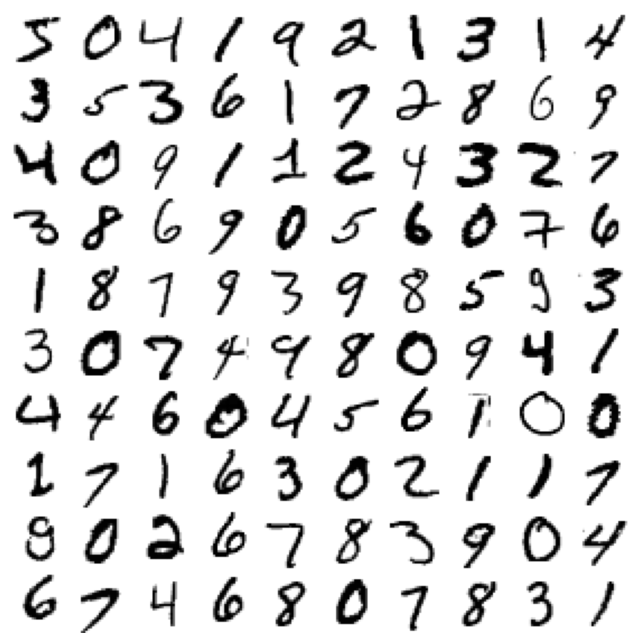

In [12]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### **Training a Binary Classifier**

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

### **Performance Measures**

#### **Measuring Accuracy Using Cross-Validation**

**Lớp StratifiedKFold thực hiện lấy mẫu phân tầng (như được giải thích trong Chương 2) để tạo ra các nếp gấp chứa tỷ lệ đại diện của mỗi lớp. Tại mỗi lần lặp lại, mã tạo ra một bản sao của bộ phân loại, huấn luyện sao chép đó trên các nếp gấp huấn luyện và đưa ra các dự đoán trên màn hình thử nghiệm. Sau đó, nó đếm số lượng dự đoán đúng và
xuất ra tỷ lệ các dự đoán đúng**
(The StratifiedKFold class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makespredictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions)

In [17]:
# Scikit-Learn’s cross_val_score() function
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


**Note**: `shuffle=True` was omitted by mistake in previous releases of the book.

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [19]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confuion Matrix
> + Confusion matrix is a very popular measure used while solving classification problems. 
> + It can be applied to binary classification as well as for multiclass classification problems.
> + A much better way to evaluate the performance of a classifier is to look at the confusion matrix.
> + This link: **[Confusion matrix](https://www.sciencedirect.com/topics/engineering/confusion-matrix#:~:text=A%20confusion%20matrix%20is%20a,malignant%20tissue%20is%20considered%20cancerous.)**

In [21]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

> + Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
accuracy = (3530 + 53892)/(1891+ 3530 + 687 + 53892)
accuracy

0.9570333333333333

### Precision and Recall and accurancy

In [24]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [25]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(accuracy_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311
0.9570333333333333


In [26]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


In [27]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

### Precision/Recall Tradeof
> + Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

> + This confirms that raising the threshold decreases recall.

> + So how can you decide which threshold to use?
> + Đối với điều này, trước tiên, bạn sẽ cần lấy lại điểm của tất cả các phiên bản trong tập huấn luyện bằng cách sử dụng lại hàm cross_val_posystem ()

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                                method="decision_function")

In [32]:
# Tính toán các cặp nhớ lại độ chính xác cho các ngưỡng xác suất khác nhau.
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


Saving figure precision_recall_vs_threshold_plot


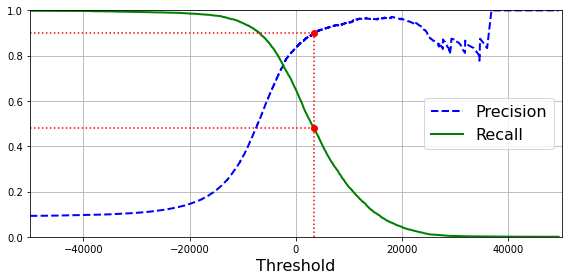

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])  


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()


+ Recall decreases when threshold increases
+ Precision decreases when threshold decrease

In [34]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


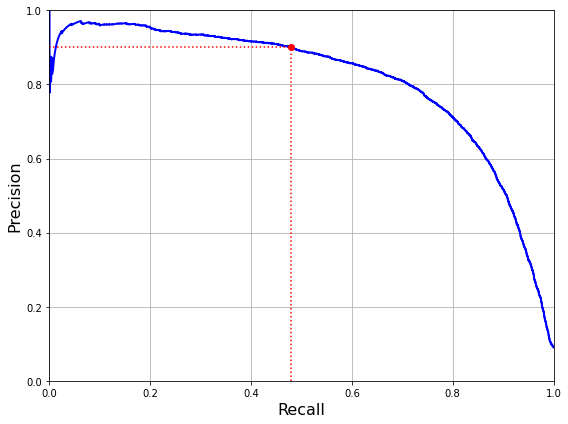

In [35]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [36]:
# Tim threshold cho precison dat 90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [38]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

+ **Một bộ phân loại có độ chính xác cao sẽ không hữu ích lắm nếu khả năng thu hồi của nó quá thấp!**

### The ROC Curve: ***[ROC](https://www.noron.vn/post/tim-hieu-chi-tiet-ve-auc---roc-trong-machine-learning-1fz9nhqo5ut)***
>+ The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers.
(Đường cong đặc tính hoạt động của máy thu (ROC) là một công cụ phổ biến khác được sử dụng với bộ phân loại nhị phân)
>+ Nó rất giống với đường cong độ chính xác / thu hồi, nhưng thay vì biểu đồ độ chính xác so với thu hồi, đường cong ROC vẽ biểu đồ tỷ lệ dương tính thực (một tên gọi khác của thu hồi) so với tỷ lệ dương tính giả.
>+ FPR là tỷ lệ các trường hợp tiêu cực được phân loại không chính xác thành tích cực. Nó bằng một trừ đi tỷ lệ âm thực, là tỷ lệ của các trường hợp tiêu cực được phân loại chính xác là tiêu cực
>+ TNR còn được gọi là độ đặc hiệu. Do đó, đường cong ROC biểu thị độ nhạy (thu hồi) so với 1 - độ đặc hiệu.

In [40]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


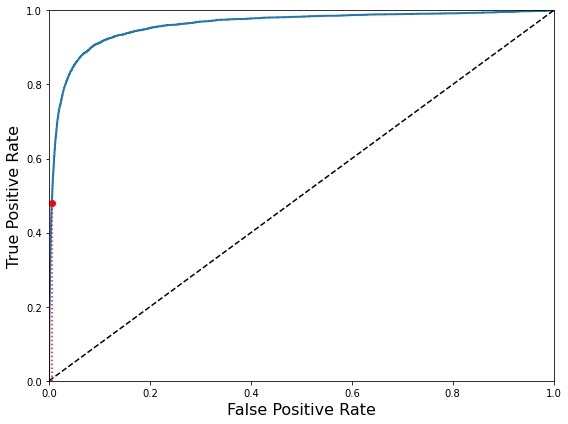

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

### **Multiclass Classification**
>+ RandomForestClassifier, naive Bayes classifiers
>+ Almost binary classification algorithms, however, OvA is preferred (one-versus-all (OvA) strategy
(also called one-versus-the-rest))
>+ OVO (This is called the one-versus-one (OvO) strategy),  If there are N classes, you need to
train N × (N – 1) / 2 classifiers.

In [42]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [44]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

>+ **Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO). Let’s try this with the SGDClassifier**

In [45]:
sgd_clf.fit(X_train, y_train) 

SGDClassifier(random_state=42)

In [46]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

>+ Nếu bạn muốn buộc ScikitLearn sử dụng  "one-versus-one"(OVO) or "one-versus-all"(OVA), bạn có thể sử dụng các lớp OneVsOneClassifier hoặc OneVsRestClassifier. Đơn giản chỉ cần tạo một thể hiện và chuyển một bộ phân loại nhị phân đến phương thức khởi tạo của nó.

In [47]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [48]:
len(ovo_clf.estimators_)

45

In [49]:
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

>+ Training a RandomForestClassifier is just as easy:

In [50]:
from random import Random
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators= 100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [51]:
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [52]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [53]:
print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))

[0.87365 0.85835 0.8689 ]


 If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. For example, simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 90%:

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

### **Error Analysis**
>+ Nếu đây là một dự án thực, bạn sẽ làm theo các bước trong danh sách kiểm tra dự án Học máy của mình : khám phá các tùy chọn chuẩn bị dữ liệu, thử nhiều mô hình, chọn lọc những mô hình tốt nhất và tinh chỉnh các siêu tham số của chúng bằng GridSearchCV, và tự động hóa nhiều nhất có thể, như bạn đã làm trong chương trước. Ở đây, chúng tôi sẽ giả định rằng bạn đã tìm thấy một mô hình đầy hứa hẹn và bạn muốn tìm cách cải thiện nó. Một cách để làm điều này là phân tích các loại lỗi mà nó gây ra.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

>+ Ma trận nhầm lẫn này trông khá ổn, vì hầu hết các hình ảnh đều nằm trên đường chéo chính, có nghĩa là chúng đã được phân loại chính xác.
>+ 5s trông tối hơn một chút so với các chữ số khác, có thể có nghĩa là có ít hình ảnh của 5s trong tập dữ liệu hoặc bộ phân loại không hoạt động tốt trên 5s cũng như các chữ số khác
>+ Hay xac minh chung

>+ **Hãy tập trung cốt truyện vào các lỗi**
>+ **Trước tiên, bạn cần chia mỗi giá trị trong ma trận nhầm lẫn cho số lượng hình ảnh trong lớp tương ứng**
>+ **Từ đó bạn có thể so sánh tỷ lệ lỗi thay vì số lỗi tuyệt đối (điều này sẽ làm cho nhiều lớp trông xấu không công bằng**

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)# mx1
norm_conf_mx = conf_mx/row_sums

Saving figure confusion_matrix_errors_plot


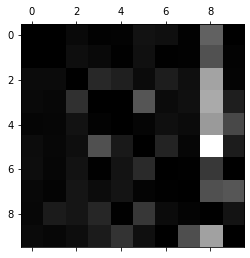

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

>+ Hãy nhớ rằng các hàng đại diện cho các lớp thực tế, trong khi các cột đại diện cho các lớp được dự đoán.
>+ Các cột cho lớp 8 và 9 khá sáng, điều này cho bạn biết rằng nhiều hình ảnh bị phân loại sai thành 8 hoặc 9.
>+ Tương tự, các hàng của lớp 8 và 9 cũng khá sáng, cho bạn biết rằng các số 8 và 9 thường bị nhầm lẫn với các chữ số khác

>+ Ngược lại, một số hàng khá tối, chẳng hạn như hàng 1: điều này có nghĩa là hầu hết các hàng 1 được phân loại chính xác (một số ít bị nhầm lẫn

#### **Phân tích ma trận nhầm lẫn thường có thể cung cấp cho bạn thông tin chi tiết về các cách cải thiện trình phân loại của bạn.**
>+ Nhìn vào cốt truyện này, có vẻ như nỗ lực của bạn nên được dành cho việc cải thiện phân loại 8s và 9s, cũng như sửa chữa sự nhầm lẫn cụ thể 3/5.
>+ Ví dụ: bạn có thể cố gắng thu thập thêm dữ liệu đào tạo cho các chữ số này. Hoặc bạn có thể thiết kế các tính năng mới sẽ giúp ích cho bộ phân loại — ví dụ: viết một thuật toán để đếm số vòng lặp đã đóng (ví dụ: 8 có hai, 6 có một, 5 không có).

#### Phân tích các lỗi riêng lẻ cũng có thể là một cách tốt để hiểu rõ hơn về công việc mà trình phân loại của bạn đang làm và tại sao nó không thành công, nhưng việc này khó hơn và tốn nhiều thời gian hơn.
>+ Ví dụ với 3 và 5

Saving figure error_analysis_digits_plot


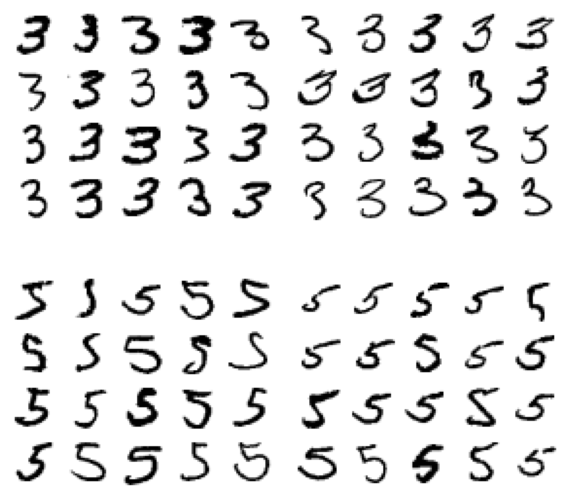

In [ ]:
from matplotlib.pyplot import cla


cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a ) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:20], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:20], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:20], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:20], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

>+ Hai khối 5 × 5 ở bên trái hiển thị các chữ số được phân loại là 3 và hai khối 5 × 5 ở bên phải hiển thị các hình ảnh được phân loại là 5.
>+ Tuy nhiên, hầu hết các hình ảnh bị phân loại sai có vẻ như là những lỗi rõ ràng đối với chúng tôi và thật khó hiểu tại sao trình phân loại lại mắc lỗi như vậy
>+ Lý do là chúng tôi đã sử dụng một SGDClassifier đơn giản, là một mô hình tuyến tính

+ Sự khác biệt chính giữa 3s và 5s là vị trí của dòng nhỏ nối dòng trên cùng với cung dưới cùng. Nếu bạn vẽ một số 3 với đường giao nhau hơi lệch sang trái, bộ phân loại có thể phân loại nó thành số 5 và ngược lại. Nói cách khác, bộ phân loại này khá nhạy cảm với việc dịch chuyển và xoay hình ảnh. Vì vậy, một cách để giảm sự nhầm lẫn 3/5
sẽ là xử lý trước các hình ảnh để đảm bảo rằng chúng được căn giữa tốt và không bị xoay quá nhiều.

### **Multilabel Classification**
>+ Ví dụ: hãy xem xét một bộ phân loại nhận dạng khuôn mặt: nó phải làm gì nếu nó nhận ra nhiều người trên cùng một bức ảnh?

>+ Giả sử bộ phân loại đã được đào tạo để nhận dạng ba khuôn mặt, Alice, Bob và Charlie; sau đó khi nó được hiển thị hình ảnh của Alice và Charlie, nó sẽ xuất ra [1, 0, 1] (nghĩa là “Alice có, Bob không, Charlie có”). Một hệ thống phân loại như vậy tạo ra nhiều
nhãn nhị phân được gọi là hệ thống phân loại đa nhãn.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Mã này tạo ra một mảng y_multilabel chứa hai nhãn đích cho mỗi hình ảnh chữ số: nhãn đầu tiên cho biết chữ số có lớn hay không (7, 8 hoặc 9) và nhãn thứ hai cho biết nó có phải là số lẻ hay không.

Bây giờ bạn có thể đưa ra dự đoán và nhận thấy rằng nó xuất ra hai nhãn:

In [ ]:
knn_clf.predict([some_digit]) # Chữ số 5 đúng là không lớn (Sai) và lẻ (Đúng)

array([[False,  True]])

#### **There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project.**

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Phân loại đa đầu ra (Multioutput Classification)

In [ ]:
import numpy as np
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

NameError: name 'X_train' is not defined

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)